In [31]:
%%capture
%run "4 - Linear Algebra.ipynb"
%run "5 - Statistics.ipynb"
%run "6 - Probability.ipynb"
%run "8 - Gradient Descent.ipynb"

# Exploring Your Data
Before you start building models and looking for answers, you should explore the data.

## Exploring One-Dimensional Data
One-dimensional data is just a collection of some type, e.g., numbers.

A good place to start is with summary statistics.

In [2]:
def bucketize(point, bucket_size):
    """floor the point to the next lower multiple of bucket size"""
    return bucket_size * math.floor(point / bucket_size)

def make_histogram(points, bucket_size):
    return Counter(bucketize(point, bucket_size) for point in points)

def plot_histogram(points, bucket_size, title=''):
    histogram = make_histogram(points, bucket_size)
    plt.bar(list(histogram.keys()), histogram.values(), width=bucket_size, edgecolor='white')
    plt.title(title)
    plt.show()

In [3]:
import random

random.seed(0)

# uniform #'s will be between -100 and 100
uniform = [200 * random.random() - 100 for _ in range(10000)]

# normal #'s will be from the normal distribution with mean of 0 and standard deviation of 57
normal = [57 * inverse_normal_cdf(random.random()) for _ in range(10000)]

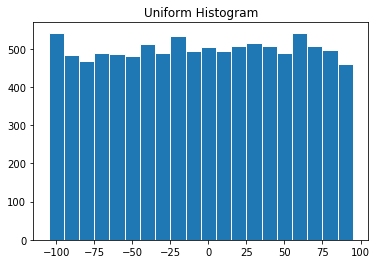

In [4]:
plot_histogram(uniform, 10, 'Uniform Histogram')

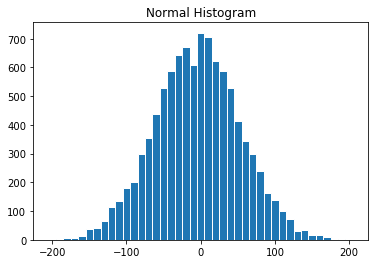

In [5]:
plot_histogram(normal, 10, 'Normal Histogram')

## Two Dimensions

In [6]:
def random_normal():
    """retuns random #'s from standard normal distribution"""
    return inverse_normal_cdf(random.random())

xs = [random_normal() for _ in range(1000)]
ys1 = [x + random_normal() / 2 for x in xs]
ys2 = [-x + random_normal() / 2 for x in xs]

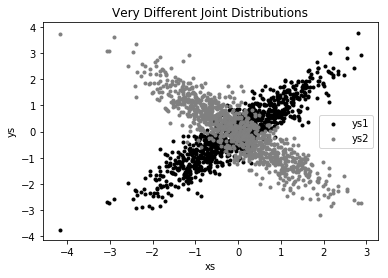

In [7]:
plt.scatter(xs, ys1, marker='.', color='black', label='ys1');
plt.scatter(xs, ys2, marker='.', color='gray', label='ys2');
plt.xlabel('xs');
plt.ylabel('ys');
plt.legend(loc=5);
plt.title('Very Different Joint Distributions');

In [8]:
correlation(xs, ys1), correlation(xs, ys2)

(0.9010493686379609, -0.8920981526880033)

## Many Dimensions
An easy way to investigate relationships between many dimensions is with a _correlation matrix_.

In [9]:
def correlation_matrix(data):
    """returns a matrix where x_ij is the correlation between col i and col j"""
    _, num_cols = shape(data)
    
    def matrix_entry(i, j):
        return correlation(get_column(data, i), get_column(data, j))
    
    return make_matrix(num_cols, num_cols, matrix_entry)

In [10]:
data = [[x, y1, y2] for (x, y1, y2) in zip(xs, ys1, ys2)]
correlation_matrix(data)

[[1.0, 0.9010493686379609, -0.8920981526880033],
 [0.9010493686379609, 1.0, -0.8072731481569311],
 [-0.8920981526880033, -0.8072731481569311, 1.0]]

(-4.582970604464971, 3.283474907443487)

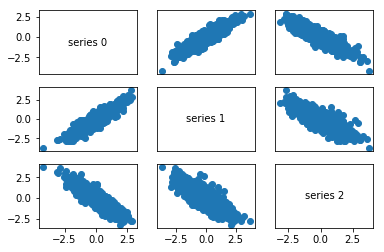

In [11]:
_, num_columns = shape(data)
fig, ax = plt.subplots(num_columns, num_columns)

for i in range(num_columns):
    for j in range(num_columns):
        # scatter column_j on the x-axis vs column_i on the y-axis
        if i != j: ax[i][j].scatter(get_column(data, j), get_column(data, i))
            
        # unless i == j, in which case show the series name
        else: ax[i][j].annotate("series " + str(i), (0.5, 0.5), xycoords='axes fraction', ha="center", va="center")
            
        # then hide axis labels except left and bottom charts
        if i < num_columns - 1: ax[i][j].xaxis.set_visible(False)
        if j > 0: ax[i][j].yaxis.set_visible(False)
        
# fix the bottom right and top left axis labels, which are wrong because
# their charts only have text in them
ax[-1][-1].set_xlim(ax[0][-1].get_xlim())
ax[0][0].set_ylim(ax[0][1].get_ylim())

# Cleaning And Munging

In [12]:
def parse_row(input_row, parsers):
    """given a list of parsers (some of which may be None)
    apply the appropriate one to each element of the input_row"""
    return [parser(value) if parser is not None else value for value, parser in zip(input_row, parsers)]

def parse_rows_with(reader, parsers):
    """wrap a reader to apply the parsers to each of its rows"""
    for row in reader:
        yield parse_row(row, parsers)

In [13]:
def try_or_none(f):
    """wraps f to return None if f raises an exception
    assumes f takes only one input"""
    def f_or_none(x):
        try: return f(x)
        except: return None
    return f_or_none

In [14]:
def parse_row(input_row, parsers):
    return [try_or_none(parser)(value) if parser is not None else value for value, parser in zip(input_row, parsers)]

In [15]:
import dateutil.parser
import csv

data = []

with open("stocks.csv", "r") as f:
    reader = csv.reader(f)
    for line in parse_rows_with(reader, [dateutil.parser.parse, None, float]):
        data.append(line)
        
data

[[datetime.datetime(2014, 6, 20, 0, 0), 'AAPL', 90.91],
 [datetime.datetime(2014, 6, 20, 0, 0), 'MSFT', 41.68],
 [datetime.datetime(2014, 6, 20, 0, 0), 'FB', 64.5],
 [datetime.datetime(2014, 6, 21, 0, 0), 'AAPL', 91.28],
 [datetime.datetime(2014, 6, 21, 0, 0), 'MSFT', 40.37],
 [datetime.datetime(2014, 6, 21, 0, 0), 'FB', 64.92]]

# Manipulating Data

In [16]:
max_aapl_price = max(row[2]
                     for row in data
                     if row[1] == "AAPL")
max_aapl_price

91.28

# Rescaling
When working with data, many calculations are sensitive to the _scale_ of the data. Consider clustering as an example:

In [18]:
import pandas as pd

pd.DataFrame({'Height (inches)': [63, 67, 70], 'Height (centimeters)': [160, 170.2, 177.8], 'Weight': [150, 160, 171]}, index=['A', 'B', 'C'])

,Height (centimeters),Height (inches),Weight
A,160.0,63,150
B,170.2,67,160
C,177.8,70,171


If we use inches, B's closest neighbor is A:

In [19]:
a_to_b = distance([63, 150], [67, 160])
a_to_c = distance([63, 150], [70, 171])
b_to_c = distance([67, 160], [70, 171])

a_to_b, a_to_c, b_to_c

(10.770329614269007, 22.135943621178654, 11.40175425099138)

But if we use centimeters, the closest neighbor is C:

In [20]:
a_to_b = distance([160, 150], [170.2, 160])
a_to_c = distance([160, 150], [177.8, 171])
b_to_c = distance([170.2, 160], [177.8, 171])

a_to_b, a_to_c, b_to_c

(14.284257068535268, 27.52889391167034, 13.370115930686627)

When results are impacted by units of measure like in the above example, scaling can help. Rescaling projects values into a dimension with mean 0 and standard deviation 1. This effectively converts data into a common unit of "standard deviations from the mean."

In [21]:
def scale(data_matrix):
    """returns the means and standard deviations of each column"""
    num_rows, num_cols = shape(data_matrix)
    means = [mean(get_column(data_matrix,j)) for j in range(num_cols)]
    stdevs = [standard_deviation(get_column(data_matrix,j)) for j in range(num_cols)]
    
    return means, stdevs

In [22]:
def rescale(data_matrix):
    """rescales the input data so that each column
    has mean 0 and standard deviation 1
    leaves alone columns with no deviation"""
    means, stdevs = scale(data_matrix)
    
    def rescaled(i, j):
        if stdevs[j] > 0:
            return (data_matrix[i][j] - means[j]) / stdevs[j]
        else:
            return data_matrix[i][j]
    
    num_rows, num_cols = shape(data_matrix)
    return make_matrix(num_rows, num_cols, rescaled)

Rescale our weights so that they do not differ by units:

In [23]:
hts_in = [[63], [67], [70]]
hts_cm = [[160], [170.2], [177.8]]
wts = [[150], [160], [171]]

hts_in_rescaled = rescale(hts_in)
hts_cm_rescaled = rescale(hts_cm)
wts_rescaled = rescale(wts)

hts_in_rescaled, hts_cm_rescaled, wts_rescaled

([[-1.0440737953277504], [0.09491579957524855], [0.9491579957524977]],
 [[-1.0449798276855173], [0.09703384114222419], [0.9479459865432901]],
 [[-0.9837552647618352], [-0.03173404079876975], [1.0154893055606022]])

Now when we calculate distances, you can see that we end up with almost equivalent calculations for inches as we do centimeters:

In [24]:
a_to_b_rescaled = distance([hts_in_rescaled[0][0], wts_rescaled[0][0]], [hts_in_rescaled[1][0], wts_rescaled[1][0]])
a_to_c_rescaled = distance([hts_in_rescaled[0][0], wts_rescaled[0][0]], [hts_in_rescaled[2][0], wts_rescaled[2][0]])
b_to_c_rescaled = distance([hts_in_rescaled[1][0], wts_rescaled[1][0]], [hts_in_rescaled[2][0], wts_rescaled[2][0]])

a_to_b_rescaled, a_to_c_rescaled, b_to_c_rescaled

(1.4844668093876099, 2.823110310444266, 1.3514460651057634)

In [25]:
a_to_b_rescaled = distance([hts_cm_rescaled[0][0], wts_rescaled[0][0]], [hts_cm_rescaled[1][0], wts_rescaled[1][0]])
a_to_c_rescaled = distance([hts_cm_rescaled[0][0], wts_rescaled[0][0]], [hts_cm_rescaled[2][0], wts_rescaled[2][0]])
b_to_c_rescaled = distance([hts_cm_rescaled[1][0], wts_rescaled[1][0]], [hts_cm_rescaled[2][0], wts_rescaled[2][0]])

a_to_b_rescaled, a_to_c_rescaled, b_to_c_rescaled

(1.4867883610875934, 2.8228942865405537, 1.349343624267431)

# Dimensionality Reduction
On occasion, the actually useful dimension of the data might not correspond to the dimensions that we possess in the data. We can use _principal component analysis_ to extract one or more dimensions associated with as much of the variation as possible.

In [26]:
pca_data = [[7, 4, 3],
            [4, 1, 8],
            [6, 3, 5],
            [8, 6, 1],
            [8, 5, 7],
            [7, 2, 9],
            [5, 3, 3],
            [9, 5, 8],
            [7, 4, 5],
            [8, 2, 2]]

In [27]:
def de_mean_matrix(A):
    """Returns each value in columns of A minus the mean of
    that column resulting in mean of 0 for all columns"""
    nr, nc = shape(A)
    column_means, _ = scale(A)
    return make_matrix(nr, nc, lambda i, j: A[i][j] - column_means[j])

pca_data_de_mean = de_mean_matrix(pca_data)
pca_data_de_mean

[[0.09999999999999964, 0.5, -2.0999999999999996],
 [-2.9000000000000004, -2.5, 2.9000000000000004],
 [-0.9000000000000004, -0.5, -0.09999999999999964],
 [1.0999999999999996, 2.5, -4.1],
 [1.0999999999999996, 1.5, 1.9000000000000004],
 [0.09999999999999964, -1.5, 3.9000000000000004],
 [-1.9000000000000004, -0.5, -2.0999999999999996],
 [2.0999999999999996, 1.5, 2.9000000000000004],
 [0.09999999999999964, 0.5, -0.09999999999999964],
 [1.0999999999999996, -1.5, -3.0999999999999996]]

With the de-meaned matrix, we can figure out which direction captures the most variance in the data:

In [28]:
def direction(w):
    mag = magnitude(w)
    return [w_i / mag for w_i in w]

pca_data_direction = [direction(w) for w in pca_data_de_mean]
pca_data_direction

[[0.0462744813382746, 0.23137240669137382, -0.9717641081037699],
 [-0.6037737126955562, -0.5204945799099622, 0.6037737126955562],
 [-0.8700628401410974, -0.48336824452283167, -0.09667364890456599],
 [0.2232840993890228, 0.5074638622477793, -0.8322407340863579],
 [0.4136975779445307, 0.5641330608334512, 0.7145685437223716],
 [0.023925088201495467, -0.3588763230224333, 0.9330784398583265],
 [-0.660694735299685, -0.17386703560518024, -0.7302415495417569],
 [0.5409569048698275, 0.386397789192734, 0.7470357257726191],
 [0.1924500897298746, 0.9622504486493764, -0.1924500897298746],
 [0.3042670272498506, -0.4149095826134328, -0.857479804067761]]

Now we can compute the variance of the data in the direction, w:

In [29]:
def directional_variance_i(x_i, w):
    """the variance of the row x_i in the direction determined by w"""
    return dot(x_i, direction(w)) ** 2

def directional_variance(X, w):
    """the variance of the data in the direction determined w"""
    return sum(directional_variance_i(x_i, w) for x_i in X)

def directional_variance_gradient_i(x_i, w):
    """the contribution of row x_i to the gradient of
    the direction-w variance"""
    projection_length = dot(x_i, direction(w))
    return [2 * projection_length * x_ij for x_ij in x_i]

def directional_variance_gradient(X, w):
    return vector_sum(directional_variance_gradient_i(x_i, w) for x_i in X)

pca_data_variance = [directional_variance(pca_data_direction, w) for w in pca_data_direction]
pca_data_variance

[5.216675521874882,
 4.204616126004593,
 3.5867789170376807,
 4.809491792522239,
 4.5776695749460385,
 5.070989204751487,
 4.4938352470231475,
 4.73961211667863,
 3.2386164653115332,
 3.743983759490656]

The _first principal component_ is the direction that maximizes the directional variance above.

In [35]:
def first_principal_component(X):
    guess = [1 for _ in X[0]]
    unscaled_maximizer = maximize_batch(
        partial(directional_variance, X), # is now a function of w
        partial(directional_variance_gradient, X), # is now a function of w
        guess)
    return direction(unscaled_maximizer)

first_principal_component(pca_data)

[0.7347392109132538, 0.3763799180143898, 0.5643548965518509]

We can use stochastic gradient descent here:

In [34]:
def first_principal_component_sgd(X):
    guess = [1 for _ in X[0]]
    unscaled_maximizer = maximize_stochastic(
        lambda x, _, w: directional_variance_i(x, w),
        lambda x, _, w: directional_variance_gradient_i(x, w),
        X,
        [None for _ in X], # the fake "y"
        guess)
    return direction(unscaled_maximizer)

first_principal_component_sgd(pca_data)

[0.5773502691896258, 0.5773502691896258, 0.5773502691896258]